In [1]:
# Import required libraries
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
from phone_diagnostics_analysis import (
    PhoneDiagnosticParser,
    analyze_battery_health,
    analyze_process_performance,
    analyze_battery_drain_sources,
    create_visualizations,
    create_enhanced_visualizations,
    export_data,
    run_complete_analysis
)
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")
print("Enhanced diagnostic analysis functions loaded!")


Libraries imported successfully!
Enhanced diagnostic analysis functions loaded!


In [2]:
# Initialize the diagnostic parser
parser = PhoneDiagnosticParser()

# Discover all diagnostic sessions
print("Discovering diagnostic sessions...")
sessions = parser.discover_sessions()

if sessions:
    print(f"Found {len(sessions)} diagnostic sessions:")
    for session_name, session_info in sessions.items():
        timestamp_str = session_info['timestamp'].strftime('%Y-%m-%d %H:%M:%S') if session_info['timestamp'] else 'Unknown'
        file_count = len(session_info['files'])
        print(f"  - {session_name}: {timestamp_str} ({file_count} files)")
else:
    print("No diagnostic sessions found. Please check your logs directory.")


Discovering diagnostic sessions...
Found 3 diagnostic sessions
Found 3 diagnostic sessions:
  - 23-Aug-25_03-20-07-44: 2025-08-23 03:20:07 (31 files)
  - 23-Aug-25_03-26-38-46: 2025-08-23 03:26:38 (31 files)
  - 23-Aug-25_04-27-29-59: 2025-08-23 04:27:29 (31 files)


In [3]:
# Parse all diagnostic sessions
print("\nParsing all diagnostic sessions...")
parsed_data = parser.parse_all_sessions()

# Create summary DataFrame
print("\nCreating summary data...")
summary_df = parser.get_summary_dataframe()

# Display summary information
print(f"\nSummary DataFrame Shape: {summary_df.shape}")
print(f"Columns: {list(summary_df.columns)}")
print(f"Total Sessions: {len(summary_df)}")

# Display the summary DataFrame
print("\nSummary of all diagnostic sessions:")
display(summary_df)


Parsing all diagnostic sessions...
Parsing session: 23-Aug-25_03-20-07-44
Parsing session: 23-Aug-25_03-26-38-46
Parsing session: 23-Aug-25_04-27-29-59
Parsed 3 sessions

Creating summary data...

Summary DataFrame Shape: (3, 24)
Columns: ['session', 'timestamp', 'files_parsed', 'battery_level', 'battery_voltage', 'battery_temperature', 'charging_status', 'ac_powered', 'usb_powered', 'phone_temp', 'model', 'brand', 'android_version', 'cpu_temp', 'gpu_temp', 'battery_temp_thermal', 'skin_temp', 'total_processes', 'total_ram_gb', 'used_ram_mb', 'ram_usage_percent', 'total_screen_time_ms', 'total_cpu_time_ms', 'total_wake_lock_ms']
Total Sessions: 3

Summary of all diagnostic sessions:


,session,timestamp,files_parsed,battery_level,battery_voltage,battery_temperature,charging_status,ac_powered,usb_powered,phone_temp,...,gpu_temp,battery_temp_thermal,skin_temp,total_processes,total_ram_gb,used_ram_mb,ram_usage_percent,total_screen_time_ms,total_cpu_time_ms,total_wake_lock_ms
0,23-Aug-25_03-20-07-44,2025-08-23 03:20:07,9,38,3,33.2,2,False,True,34.0,...,38.514,33.2,36.325,838,7.37299,2879.665039,38.141555,0,0,0
1,23-Aug-25_03-26-38-46,2025-08-23 03:26:38,9,40,3,32.8,2,False,True,33.0,...,37.628,32.8,35.402,838,7.37299,3045.368164,40.336315,0,0,0
2,23-Aug-25_04-27-29-59,2025-08-23 04:27:29,9,50,3,34.0,2,False,True,35.0,...,39.095,34.0,36.776,458,7.37299,3527.733398,46.725308,0,0,0


In [4]:
# Get the latest session with parsed data
if parsed_data:
    latest_session_name = list(parsed_data.keys())[-1]
    latest_data = parsed_data[latest_session_name]
    
    print(f"=== DETAILED INFORMATION FOR LATEST SESSION: {latest_session_name} ===\n")
    
    # Display timestamp
    if latest_data['timestamp']:
        print(f"Timestamp: {latest_data['timestamp']}")
    else:
        print("Timestamp: None (parsing issue)")
    
    # Display files parsed
    print(f"Files Parsed: {latest_data['files_parsed']}")
    
    # Display battery information
    if 'battery_basic' in latest_data:
        print(f"\n--- Battery Basic Information ---")
        battery = latest_data['battery_basic']
        for key, value in battery.items():
            print(f"  {key}: {value}")
    
    # Display device information
    if 'device_info' in latest_data:
        print(f"\n--- Device Information ---")
        device = latest_data['device_info']
        for key, value in device.items():
            print(f"  {key}: {value}")
    
    # Display thermal information
    if 'thermal' in latest_data:
        print(f"\n--- Thermal Information ---")
        thermal = latest_data['thermal']
        if 'temperatures' in thermal:
            for name, temp_info in thermal['temperatures'].items():
                print(f"  {name}: {temp_info['value']}°C (Type: {temp_info['type']})")
    
    # Display process statistics
    if 'procstats' in latest_data:
        print(f"\n--- Process Statistics ---")
        procstats = latest_data['procstats']
        print(f"  Total Processes: {procstats.get('total_processes', 'N/A')}")
        if 'processes' in procstats and procstats['processes']:
            print(f"  Sample Process: {procstats['processes'][0]['package_name']}")
    
    # Display memory information
    if 'memory_info' in latest_data:
        print(f"\n--- Memory Information ---")
        memory = latest_data['memory_info']
        print(f"  Total RAM: {memory.get('total_ram_gb', 'N/A'):.2f} GB")
        print(f"  Used RAM: {memory.get('used_ram_mb', 'N/A'):.1f} MB")
        print(f"  RAM Usage: {memory.get('ram_usage_percent', 'N/A'):.1f}%")
    
    # Display battery stats detailed
    if 'battery_stats_detailed' in latest_data:
        print(f"\n--- Detailed Battery Statistics ---")
        battery_detailed = latest_data['battery_stats_detailed']
        print(f"  Period: {battery_detailed.get('period', 'N/A')}")
        print(f"  Total Apps: {battery_detailed.get('total_apps', 'N/A')}")
        print(f"  Total Screen Time: {battery_detailed.get('total_screen_time_ms', 'N/A')} ms")
        print(f"  Total CPU Time: {battery_detailed.get('total_cpu_time_ms', 'N/A')} ms")
        print(f"  Total Wake Lock Time: {battery_detailed.get('total_wake_lock_ms', 'N/A')} ms")

=== DETAILED INFORMATION FOR LATEST SESSION: 23-Aug-25_04-27-29-59 ===

Timestamp: 2025-08-23 04:27:29
Files Parsed: ['battery_basic.txt', 'battery_stats_detailed.txt', 'cpuinfo.txt', 'device_info.txt', 'memory_info.txt', 'power.txt', 'procstats.txt', 'thermal.txt', 'usage_stats.txt']

--- Battery Basic Information ---
  oplus_Charger voltage: 4725
  oplus_Battery current: -176
  oplus_ChargerTechnology: 0
  oplus_ChargeFastCharger: False
  oplus_PlugType: 2
  oplus_UpdatesStopped: False
  oplus_UsbHwStatus: 0
  oplus_BatteryHwStatus: 1
  oplus_HwStatusIsSet: 1
  oplus_BatteryIcStatus: 1
  oplus_IcStatusIsSet: 1
  oplus_mUsbStatus: 0
  oplus_PhoneTemp: 35.0
  oplus_ThermalFeatureOn: True
  std_AC powered: False
  std_USB powered: True
  std_Wireless powered: False
  std_Max charging current: 500000
  std_Max charging voltage: 5000000
  std_Charge counter: 2250000
  std_status: 2
  std_health: 2
  std_present: True
  std_level: 50
  std_scale: 100
  std_voltage: 3
  std_temperature: 34.

In [5]:
# Get the latest session with parsed data
if parsed_data:
    latest_session_name = list(parsed_data.keys())[-1]
    latest_data = parsed_data[latest_session_name]
    
    print(f"=== DETAILED INFORMATION FOR LATEST SESSION: {latest_session_name} ===\n")
    
    # Display timestamp
    if latest_data['timestamp']:
        print(f"Timestamp: {latest_data['timestamp']}")
    else:
        print("Timestamp: None (parsing issue)")
    
    # Display files parsed
    print(f"Files Parsed: {latest_data['files_parsed']}")
    
    # Display battery information
    if 'battery_basic' in latest_data:
        print(f"\n--- Battery Basic Information ---")
        battery = latest_data['battery_basic']
        for key, value in battery.items():
            print(f"  {key}: {value}")
    
    # Display device information
    if 'device_info' in latest_data:
        print(f"\n--- Device Information ---")
        device = latest_data['device_info']
        for key, value in device.items():
            print(f"  {key}: {value}")
    
    # Display thermal information
    if 'thermal' in latest_data:
        print(f"\n--- Thermal Information ---")
        thermal = latest_data['thermal']
        if 'temperatures' in thermal:
            for name, temp_info in thermal['temperatures'].items():
                print(f"  {name}: {temp_info['value']}°C (Type: {temp_info['type']})")
    
    # Display process statistics
    if 'procstats' in latest_data:
        print(f"\n--- Process Statistics ---")
        procstats = latest_data['procstats']
        print(f"  Total Processes: {procstats.get('total_processes', 'N/A')}")
        if 'processes' in procstats and procstats['processes']:
            print(f"  Sample Process: {procstats['processes'][0]['package_name']}")
    
    # Display memory information
    if 'memory_info' in latest_data:
        print(f"\n--- Memory Information ---")
        memory = latest_data['memory_info']
        print(f"  Total RAM: {memory.get('total_ram_gb', 'N/A'):.2f} GB")
        print(f"  Used RAM: {memory.get('used_ram_mb', 'N/A'):.1f} MB")
        print(f"  RAM Usage: {memory.get('ram_usage_percent', 'N/A'):.1f}%")
    
    # Display battery stats detailed
    if 'battery_stats_detailed' in latest_data:
        print(f"\n--- Detailed Battery Statistics ---")
        battery_detailed = latest_data['battery_stats_detailed']
        print(f"  Period: {battery_detailed.get('period', 'N/A')}")
        print(f"  Total Apps: {battery_detailed.get('total_apps', 'N/A')}")
        print(f"  Total Screen Time: {battery_detailed.get('total_screen_time_ms', 'N/A')} ms")
        print(f"  Total CPU Time: {battery_detailed.get('total_cpu_time_ms', 'N/A')} ms")
        print(f"  Total Wake Lock Time: {battery_detailed.get('total_wake_lock_ms', 'N/A')} ms")

=== DETAILED INFORMATION FOR LATEST SESSION: 23-Aug-25_04-27-29-59 ===

Timestamp: 2025-08-23 04:27:29
Files Parsed: ['battery_basic.txt', 'battery_stats_detailed.txt', 'cpuinfo.txt', 'device_info.txt', 'memory_info.txt', 'power.txt', 'procstats.txt', 'thermal.txt', 'usage_stats.txt']

--- Battery Basic Information ---
  oplus_Charger voltage: 4725
  oplus_Battery current: -176
  oplus_ChargerTechnology: 0
  oplus_ChargeFastCharger: False
  oplus_PlugType: 2
  oplus_UpdatesStopped: False
  oplus_UsbHwStatus: 0
  oplus_BatteryHwStatus: 1
  oplus_HwStatusIsSet: 1
  oplus_BatteryIcStatus: 1
  oplus_IcStatusIsSet: 1
  oplus_mUsbStatus: 0
  oplus_PhoneTemp: 35.0
  oplus_ThermalFeatureOn: True
  std_AC powered: False
  std_USB powered: True
  std_Wireless powered: False
  std_Max charging current: 500000
  std_Max charging voltage: 5000000
  std_Charge counter: 2250000
  std_status: 2
  std_health: 2
  std_present: True
  std_level: 50
  std_scale: 100
  std_voltage: 3
  std_temperature: 34.

In [6]:
# Get the latest session with parsed data
if parsed_data:
    latest_session_name = list(parsed_data.keys())[-1]
    latest_data = parsed_data[latest_session_name]
    
    print(f"=== DETAILED INFORMATION FOR LATEST SESSION: {latest_session_name} ===\n")
    
    # Display timestamp
    if latest_data['timestamp']:
        print(f"Timestamp: {latest_data['timestamp']}")
    else:
        print("Timestamp: None (parsing issue)")
    
    # Display files parsed
    print(f"Files Parsed: {latest_data['files_parsed']}")
    
    # Display battery information
    if 'battery_basic' in latest_data:
        print(f"\n--- Battery Basic Information ---")
        battery = latest_data['battery_basic']
        for key, value in battery.items():
            print(f"  {key}: {value}")
    
    # Display device information
    if 'device_info' in latest_data:
        print(f"\n--- Device Information ---")
        device = latest_data['device_info']
        for key, value in device.items():
            print(f"  {key}: {value}")
    
    # Display thermal information
    if 'thermal' in latest_data:
        print(f"\n--- Thermal Information ---")
        thermal = latest_data['thermal']
        if 'temperatures' in thermal:
            for name, temp_info in thermal['temperatures'].items():
                print(f"  {name}: {temp_info['value']}°C (Type: {temp_info['type']})")
    
    # Display process statistics
    if 'procstats' in latest_data:
        print(f"\n--- Process Statistics ---")
        procstats = latest_data['procstats']
        print(f"  Total Processes: {procstats.get('total_processes', 'N/A')}")
        if 'processes' in procstats and procstats['processes']:
            print(f"  Sample Process: {procstats['processes'][0]['package_name']}")
    
    # Display memory information
    if 'memory_info' in latest_data:
        print(f"\n--- Memory Information ---")
        memory = latest_data['memory_info']
        print(f"  Total RAM: {memory.get('total_ram_gb', 'N/A'):.2f} GB")
        print(f"  Used RAM: {memory.get('used_ram_mb', 'N/A'):.1f} MB")
        print(f"  RAM Usage: {memory.get('ram_usage_percent', 'N/A'):.1f}%")
    
    # Display battery stats detailed
    if 'battery_stats_detailed' in latest_data:
        print(f"\n--- Detailed Battery Statistics ---")
        battery_detailed = latest_data['battery_stats_detailed']
        print(f"  Period: {battery_detailed.get('period', 'N/A')}")
        print(f"  Total Apps: {battery_detailed.get('total_apps', 'N/A')}")
        print(f"  Total Screen Time: {battery_detailed.get('total_screen_time_ms', 'N/A')} ms")
        print(f"  Total CPU Time: {battery_detailed.get('total_cpu_time_ms', 'N/A')} ms")
        print(f"  Total Wake Lock Time: {battery_detailed.get('total_wake_lock_ms', 'N/A')} ms")

=== DETAILED INFORMATION FOR LATEST SESSION: 23-Aug-25_04-27-29-59 ===

Timestamp: 2025-08-23 04:27:29
Files Parsed: ['battery_basic.txt', 'battery_stats_detailed.txt', 'cpuinfo.txt', 'device_info.txt', 'memory_info.txt', 'power.txt', 'procstats.txt', 'thermal.txt', 'usage_stats.txt']

--- Battery Basic Information ---
  oplus_Charger voltage: 4725
  oplus_Battery current: -176
  oplus_ChargerTechnology: 0
  oplus_ChargeFastCharger: False
  oplus_PlugType: 2
  oplus_UpdatesStopped: False
  oplus_UsbHwStatus: 0
  oplus_BatteryHwStatus: 1
  oplus_HwStatusIsSet: 1
  oplus_BatteryIcStatus: 1
  oplus_IcStatusIsSet: 1
  oplus_mUsbStatus: 0
  oplus_PhoneTemp: 35.0
  oplus_ThermalFeatureOn: True
  std_AC powered: False
  std_USB powered: True
  std_Wireless powered: False
  std_Max charging current: 500000
  std_Max charging voltage: 5000000
  std_Charge counter: 2250000
  std_status: 2
  std_health: 2
  std_present: True
  std_level: 50
  std_scale: 100
  std_voltage: 3
  std_temperature: 34.

In [7]:
# Get the latest session with parsed data
if parsed_data:
    latest_session_name = list(parsed_data.keys())[-1]
    latest_data = parsed_data[latest_session_name]
    
    print(f"=== DETAILED INFORMATION FOR LATEST SESSION: {latest_session_name} ===\n")
    
    # Display timestamp
    if latest_data['timestamp']:
        print(f"Timestamp: {latest_data['timestamp']}")
    else:
        print("Timestamp: None (parsing issue)")
    
    # Display files parsed
    print(f"Files Parsed: {latest_data['files_parsed']}")
    
    # Display battery information
    if 'battery_basic' in latest_data:
        print(f"\n--- Battery Basic Information ---")
        battery = latest_data['battery_basic']
        for key, value in battery.items():
            print(f"  {key}: {value}")
    
    # Display device information
    if 'device_info' in latest_data:
        print(f"\n--- Device Information ---")
        device = latest_data['device_info']
        for key, value in device.items():
            print(f"  {key}: {value}")
    
    # Display thermal information
    if 'thermal' in latest_data:
        print(f"\n--- Thermal Information ---")
        thermal = latest_data['thermal']
        if 'temperatures' in thermal:
            for name, temp_info in thermal['temperatures'].items():
                print(f"  {name}: {temp_info['value']}°C (Type: {temp_info['type']})")
    
    # Display process statistics
    if 'procstats' in latest_data:
        print(f"\n--- Process Statistics ---")
        procstats = latest_data['procstats']
        print(f"  Total Processes: {procstats.get('total_processes', 'N/A')}")
        if 'processes' in procstats and procstats['processes']:
            print(f"  Sample Process: {procstats['processes'][0]['package_name']}")
    
    # Display memory information
    if 'memory_info' in latest_data:
        print(f"\n--- Memory Information ---")
        memory = latest_data['memory_info']
        print(f"  Total RAM: {memory.get('total_ram_gb', 'N/A'):.2f} GB")
        print(f"  Used RAM: {memory.get('used_ram_mb', 'N/A'):.1f} MB")
        print(f"  RAM Usage: {memory.get('ram_usage_percent', 'N/A'):.1f}%")
    
    # Display battery stats detailed
    if 'battery_stats_detailed' in latest_data:
        print(f"\n--- Detailed Battery Statistics ---")
        battery_detailed = latest_data['battery_stats_detailed']
        print(f"  Period: {battery_detailed.get('period', 'N/A')}")
        print(f"  Total Apps: {battery_detailed.get('total_apps', 'N/A')}")
        print(f"  Total Screen Time: {battery_detailed.get('total_screen_time_ms', 'N/A')} ms")
        print(f"  Total CPU Time: {battery_detailed.get('total_cpu_time_ms', 'N/A')} ms")
        print(f"  Total Wake Lock Time: {battery_detailed.get('total_wake_lock_ms', 'N/A')} ms")

=== DETAILED INFORMATION FOR LATEST SESSION: 23-Aug-25_04-27-29-59 ===

Timestamp: 2025-08-23 04:27:29
Files Parsed: ['battery_basic.txt', 'battery_stats_detailed.txt', 'cpuinfo.txt', 'device_info.txt', 'memory_info.txt', 'power.txt', 'procstats.txt', 'thermal.txt', 'usage_stats.txt']

--- Battery Basic Information ---
  oplus_Charger voltage: 4725
  oplus_Battery current: -176
  oplus_ChargerTechnology: 0
  oplus_ChargeFastCharger: False
  oplus_PlugType: 2
  oplus_UpdatesStopped: False
  oplus_UsbHwStatus: 0
  oplus_BatteryHwStatus: 1
  oplus_HwStatusIsSet: 1
  oplus_BatteryIcStatus: 1
  oplus_IcStatusIsSet: 1
  oplus_mUsbStatus: 0
  oplus_PhoneTemp: 35.0
  oplus_ThermalFeatureOn: True
  std_AC powered: False
  std_USB powered: True
  std_Wireless powered: False
  std_Max charging current: 500000
  std_Max charging voltage: 5000000
  std_Charge counter: 2250000
  std_status: 2
  std_health: 2
  std_present: True
  std_level: 50
  std_scale: 100
  std_voltage: 3
  std_temperature: 34.

In [8]:
# Run comprehensive battery health analysis
print("=== COMPREHENSIVE BATTERY HEALTH ANALYSIS ===\n")
analyze_battery_health(summary_df)

=== COMPREHENSIVE BATTERY HEALTH ANALYSIS ===

=== BATTERY HEALTH ANALYSIS ===

Battery Level Statistics:
  Average: 42.7%
  Minimum: 38%
  Maximum: 50%
  Standard Deviation: 6.4%

Battery Drain Analysis:
  Average Drain Rate: 14.14% per hour
  Fastest Drain: 9.86% per hour
  Slowest Drain: 18.41% per hour
  Average Charging Rate: 14.14% per hour

=== TEMPERATURE ANALYSIS ===

Battery Temperature:
  Average: 33.3°C
  Minimum: 32.8°C
  Maximum: 34.0°C
  Standard Deviation: 0.6°C

Cpu Temp:
  Average: 38.4°C
  Minimum: 37.6°C
  Maximum: 39.1°C
  Standard Deviation: 0.7°C

Gpu Temp:
  Average: 38.4°C
  Minimum: 37.6°C
  Maximum: 39.1°C
  Standard Deviation: 0.7°C

Skin Temp:
  Average: 36.2°C
  Minimum: 35.4°C
  Maximum: 36.8°C
  Standard Deviation: 0.7°C


=== DEVICE INFORMATION ===

Device Model: IV2201
Brand: OnePlus
Android Version: 13
Total Diagnostic Sessions: 3
Data Collection Period: 0 days 01:07:22


In [9]:
# Run comprehensive process performance analysis
print("=== PROCESS PERFORMANCE ANALYSIS ===\n")
analyze_process_performance(parsed_data)

=== PROCESS PERFORMANCE ANALYSIS ===

=== PROCESS PERFORMANCE ANALYSIS ===

Session: 23-Aug-25_03-20-07-44
  Total Processes: 838
  Top 5 Most Active Processes:
    1. se.dirac.acs
       Total: 100%
       Persistent: 100%
       Service: N/A%
       Bound FG: N/A%
    2. com.google.android.apps.messaging:rcs
       Total: 100%
       Persistent: N/A%
       Service: N/A%
       Bound FG: 100%
    3. com.oplus.gesture
       Total: 100%
       Persistent: N/A%
       Service: N/A%
       Bound FG: N/A%
    4. com.heytap.accessory
       Total: 100%
       Persistent: N/A%
       Service: N/A%
       Bound FG: N/A%
    5. com.oplus.notificationmanager
       Total: 100%
       Persistent: N/A%
       Service: N/A%
       Bound FG: 99%
  Memory Usage:
    Total RAM: 7.37 GB
    Used RAM: 2879.7 MB
    RAM Usage: 38.1%
  Top 5 Memory Consumers:

Session: 23-Aug-25_03-26-38-46
  Total Processes: 838
  Top 5 Most Active Processes:
    1. se.dirac.acs
       Total: 100%
       Persistent: 1

In [10]:
# Run comprehensive battery drain source analysis
print("=== BATTERY DRAIN SOURCE ANALYSIS ===\n")
analyze_battery_drain_sources(parsed_data)

=== BATTERY DRAIN SOURCE ANALYSIS ===

=== BATTERY DRAIN SOURCE ANALYSIS ===

Session: 23-Aug-25_03-20-07-44

Session: 23-Aug-25_03-26-38-46

Session: 23-Aug-25_04-27-29-59



Creating basic visualizations...


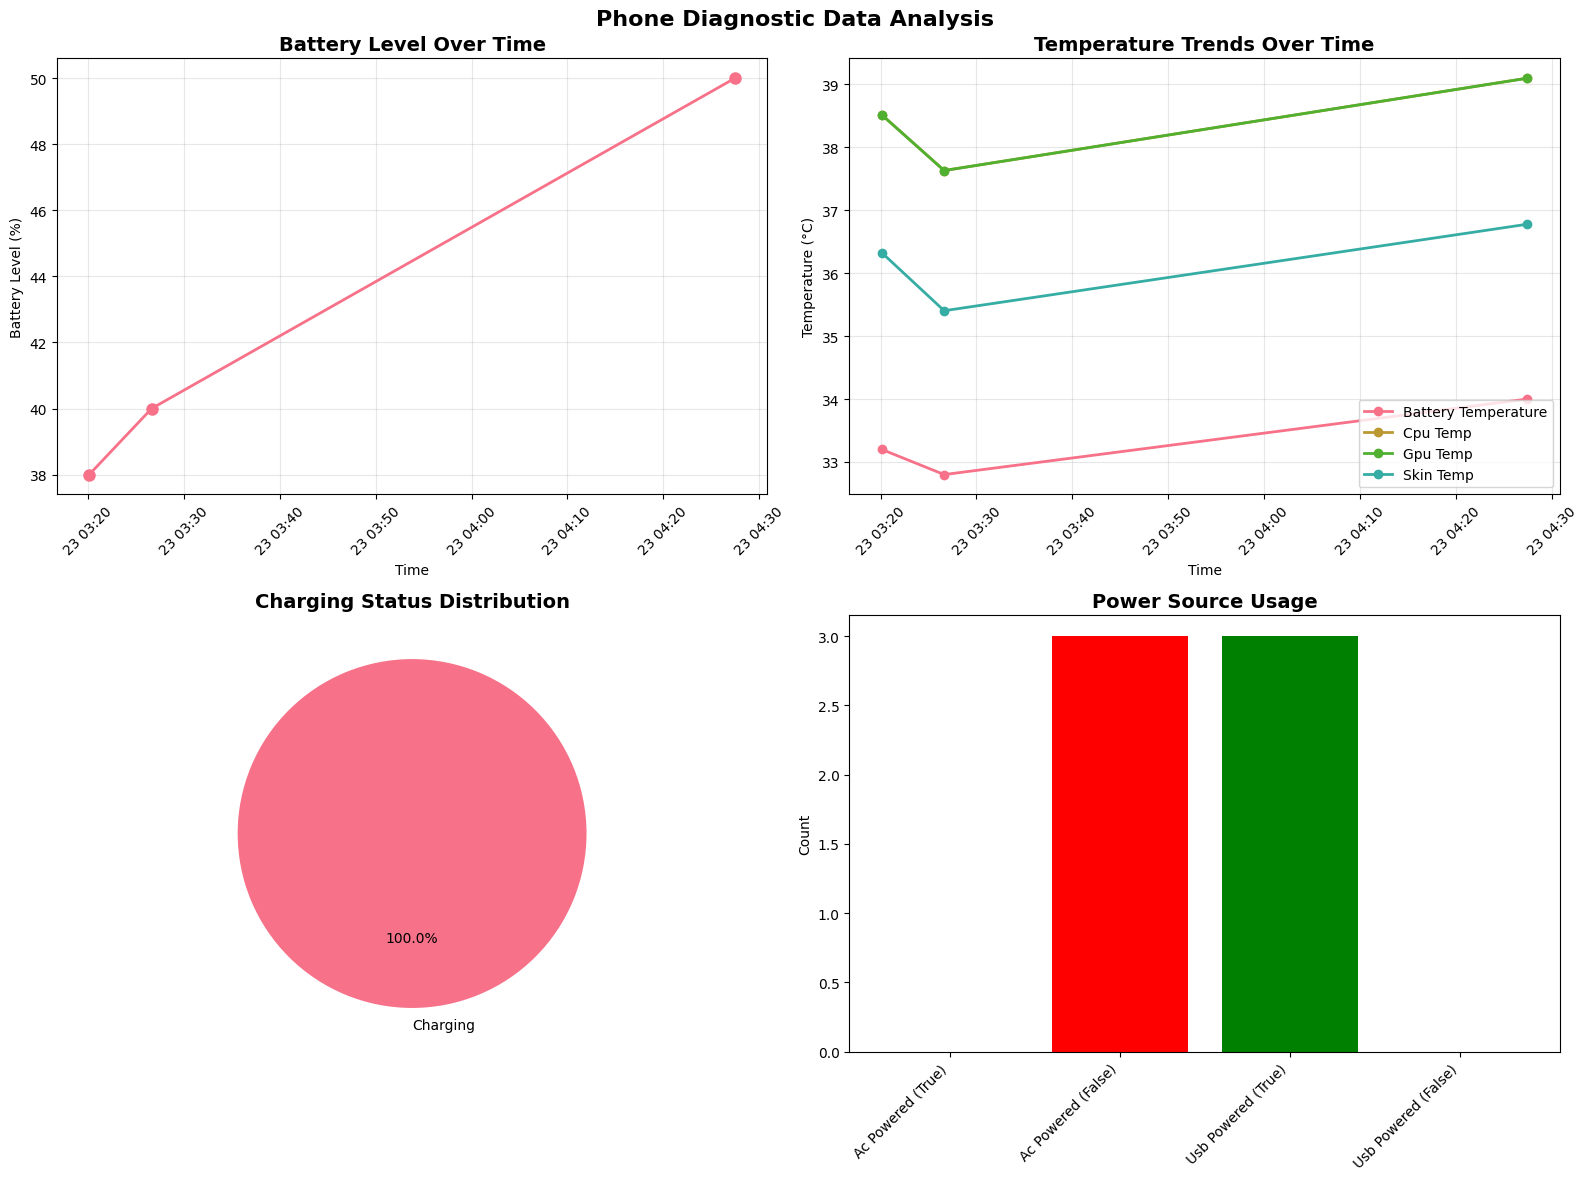

In [11]:
# Create basic diagnostic visualizations
print("Creating basic visualizations...")
create_visualizations(summary_df)

Creating enhanced process analysis visualizations...


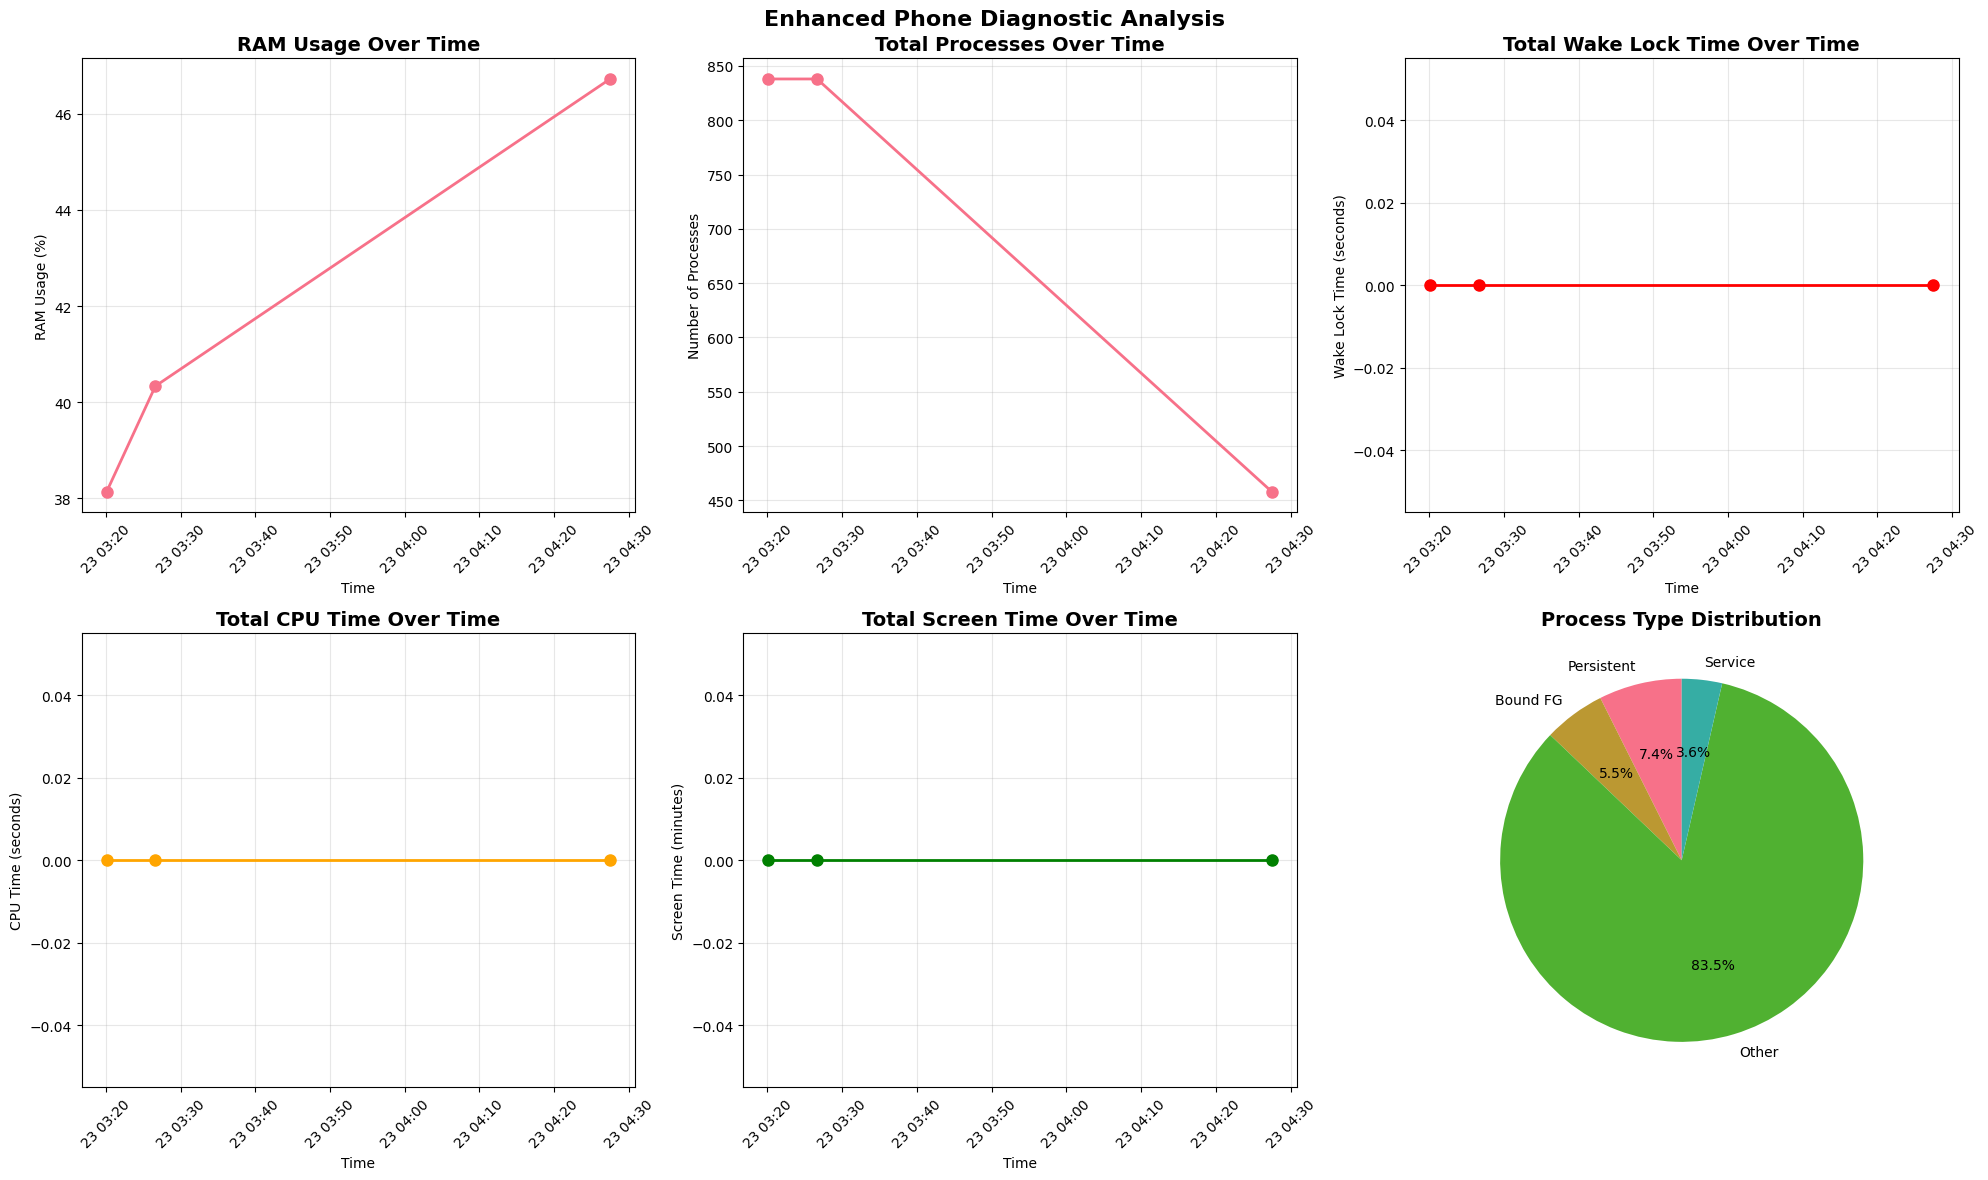

In [12]:
# Create enhanced visualizations including process analysis
print("Creating enhanced process analysis visualizations...")
create_enhanced_visualizations(summary_df, parsed_data)

In [13]:
# Export data to CSV and JSON formats
print("Exporting data for further analysis...")
export_data(summary_df, parsed_data)

Exporting data for further analysis...
Summary data exported to: phone_diagnostics_summary_20250823_042941.csv
Detailed data exported to: phone_diagnostics_detailed_20250823_042941.json

Data Export Summary:
  Total Sessions: 3
  Data Columns: 24
  Memory Usage: 1.2 KB


Running complete analysis pipeline...
=== PHONE DIAGNOSTIC DATA ANALYSIS ===

1. Discovering diagnostic sessions...
Found 3 diagnostic sessions

2. Parsing diagnostic data...
Parsing session: 23-Aug-25_03-20-07-44
Parsing session: 23-Aug-25_03-26-38-46
Parsing session: 23-Aug-25_04-27-29-59
Parsed 3 sessions

3. Creating summary data...

4. Summary of all diagnostic sessions:
                 session           timestamp  files_parsed  battery_level  \
0  23-Aug-25_03-20-07-44 2025-08-23 03:20:07             9             38   
1  23-Aug-25_03-26-38-46 2025-08-23 03:26:38             9             40   
2  23-Aug-25_04-27-29-59 2025-08-23 04:27:29             9             50   

   battery_voltage  battery_temperature  charging_status  ac_powered  \
0                3                 33.2                2       False   
1                3                 32.8                2       False   
2                3                 34.0                2       False   

   usb_powered  phone_t

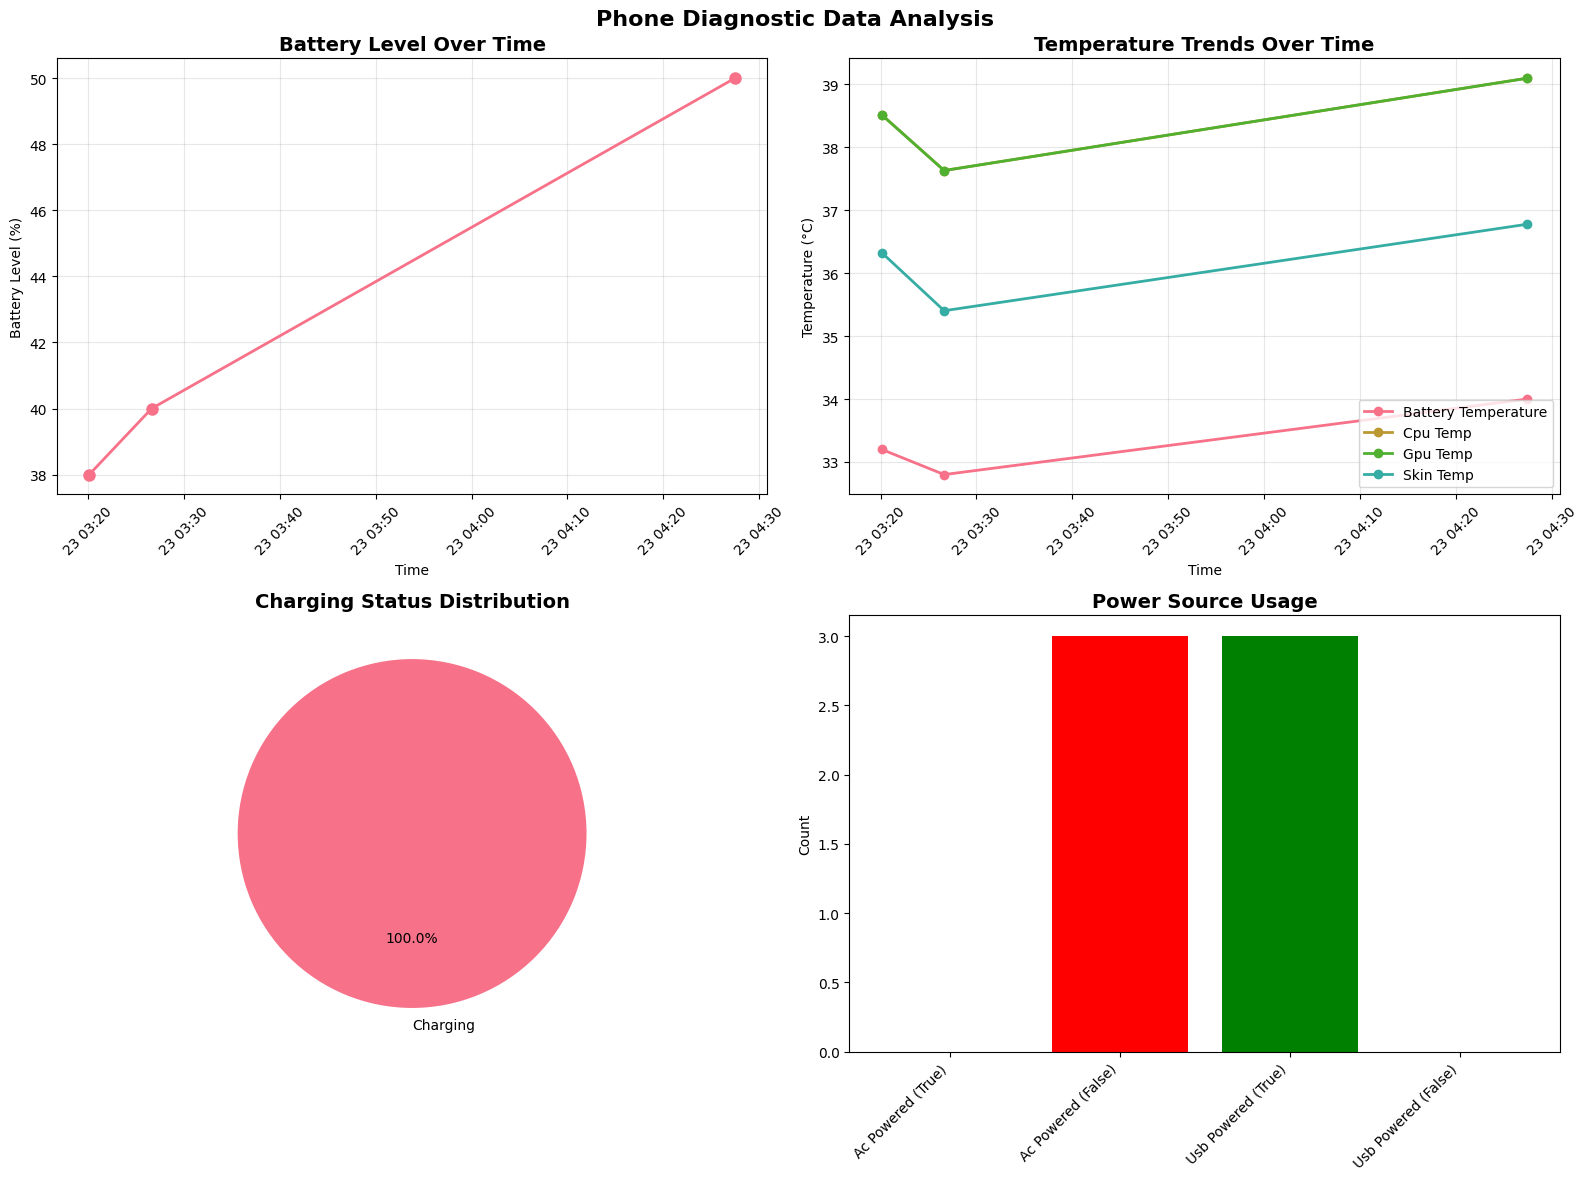


9. Creating enhanced process analysis visualizations...


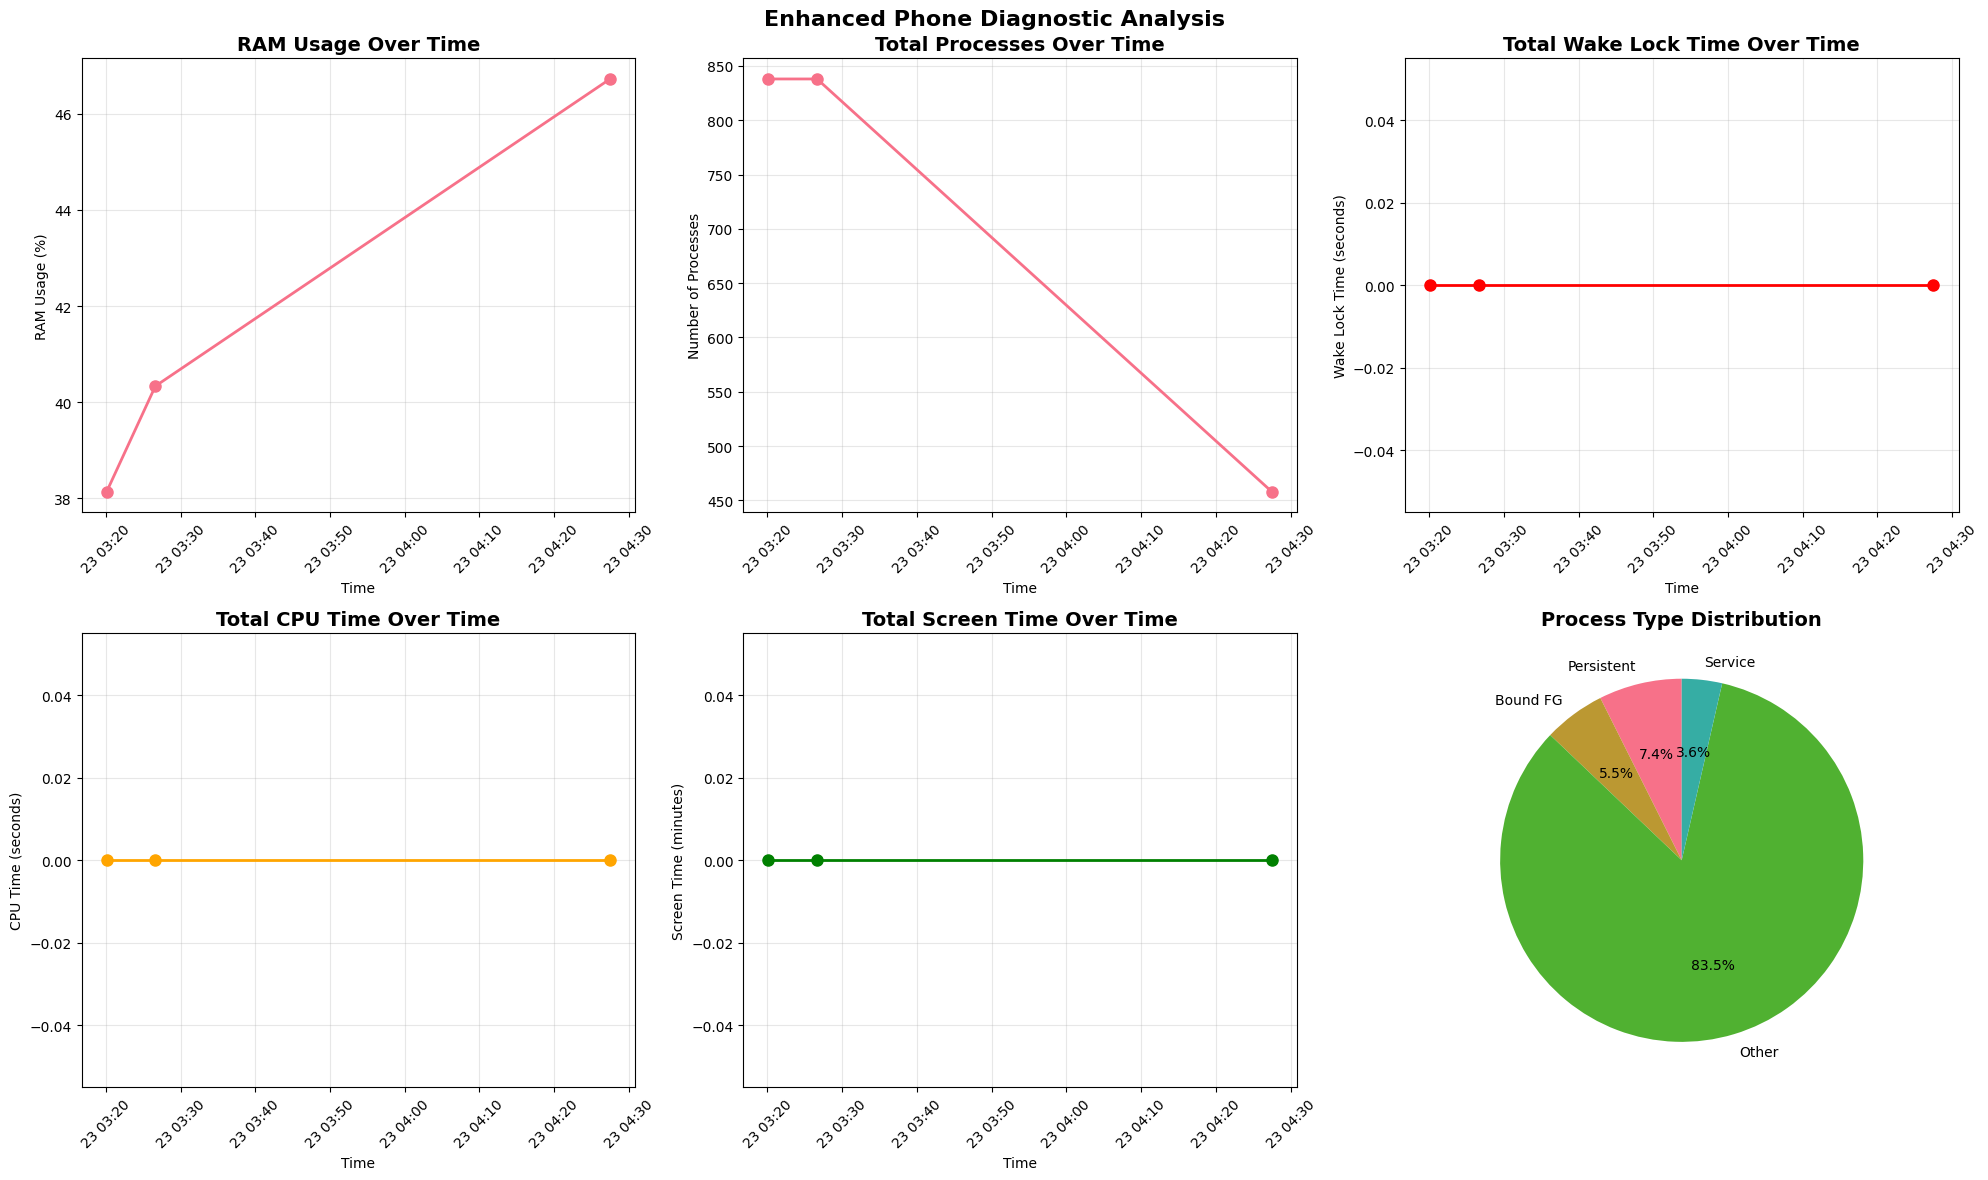


10. Exporting data...
Summary data exported to: phone_diagnostics_summary_20250823_042942.csv
Detailed data exported to: phone_diagnostics_detailed_20250823_042942.json

Data Export Summary:
  Total Sessions: 3
  Data Columns: 24
  Memory Usage: 1.2 KB

=== ANALYSIS COMPLETE ===


In [14]:
# Alternative: Run the complete analysis pipeline in one go
print("Running complete analysis pipeline...")
parser_result, summary_df_result, parsed_data_result = run_complete_analysis()

In [15]:
# Quick verification of parser and data
print("=== QUICK VERIFICATION ===\n")

# Verify parser
print(f"Parser initialized: {parser is not None}")
print(f"Parser logs directory: {parser.logs_dir}")

# Verify DataFrame
print(f"Summary DataFrame shape: {summary_df.shape}")
print(f"Summary DataFrame columns: {list(summary_df.columns)}")

# Verify parsed data
print(f"Parsed sessions count: {len(parsed_data)}")
if parsed_data:
    latest_session = list(parsed_data.keys())[-1]
    print(f"Latest session: {latest_session}")
    print(f"Files in latest session: {parsed_data[latest_session]['files_parsed']}")

# Check for specific data types
if parsed_data:
    latest_data = parsed_data[latest_session]
    data_types = {
        'battery_basic': 'Battery Information',
        'device_info': 'Device Information', 
        'thermal': 'Thermal Data',
        'procstats': 'Process Statistics',
        'memory_info': 'Memory Information',
        'battery_stats_detailed': 'Detailed Battery Stats'
    }
    
    print(f"\nData Availability Check:")
    for key, description in data_types.items():
        available = key in latest_data
        status = "✅ Available" if available else "❌ Not Available"
        print(f"  {description}: {status}")

print("\n=== VERIFICATION COMPLETE ===")

=== QUICK VERIFICATION ===

Parser initialized: True
Parser logs directory: logs
Summary DataFrame shape: (3, 24)
Summary DataFrame columns: ['session', 'timestamp', 'files_parsed', 'battery_level', 'battery_voltage', 'battery_temperature', 'charging_status', 'ac_powered', 'usb_powered', 'phone_temp', 'model', 'brand', 'android_version', 'cpu_temp', 'gpu_temp', 'battery_temp_thermal', 'skin_temp', 'total_processes', 'total_ram_gb', 'used_ram_mb', 'ram_usage_percent', 'total_screen_time_ms', 'total_cpu_time_ms', 'total_wake_lock_ms']
Parsed sessions count: 3
Latest session: 23-Aug-25_04-27-29-59
Files in latest session: ['battery_basic.txt', 'battery_stats_detailed.txt', 'cpuinfo.txt', 'device_info.txt', 'memory_info.txt', 'power.txt', 'procstats.txt', 'thermal.txt', 'usage_stats.txt']

Data Availability Check:
  Battery Information: ✅ Available
  Device Information: ✅ Available
  Thermal Data: ✅ Available
  Process Statistics: ✅ Available
  Memory Information: ✅ Available
  Detailed Ba

In [16]:
# Example: Find sessions with high memory usage
print("=== CUSTOM ANALYSIS EXAMPLES ===\n")

if 'ram_usage_percent' in summary_df.columns:
    high_memory_sessions = summary_df[summary_df['ram_usage_percent'] > 80]
    if not high_memory_sessions.empty:
        print("Sessions with High Memory Usage (>80%):")
        for _, session in high_memory_sessions.iterrows():
            print(f"  {session['session']}: {session['ram_usage_percent']:.1f}%")
    else:
        print("No sessions with memory usage above 80%")

# Example: Find sessions with high battery temperature
if 'battery_temperature' in summary_df.columns:
    high_temp_sessions = summary_df[summary_df['battery_temperature'] > 40]
    if not high_temp_sessions.empty:
        print("\nSessions with High Battery Temperature (>40°C):")
        for _, session in high_temp_sessions.iterrows():
            print(f"  {session['session']}: {session['battery_temperature']:.1f}°C")
    else:
        print("\nNo sessions with battery temperature above 40°C")

# Example: Process count analysis
if 'total_processes' in summary_df.columns:
    process_stats = summary_df['total_processes'].describe()
    print(f"\nProcess Count Statistics:")
    print(f"  Average: {process_stats['mean']:.1f}")
    print(f"  Min: {process_stats['min']:.0f}")
    print(f"  Max: {process_stats['max']:.0f}")

print("\n=== CUSTOM ANALYSIS COMPLETE ===")


=== CUSTOM ANALYSIS EXAMPLES ===

No sessions with memory usage above 80%

No sessions with battery temperature above 40°C

Process Count Statistics:
  Average: 711.3
  Min: 458
  Max: 838

=== CUSTOM ANALYSIS COMPLETE ===


In [17]:
# Check data quality and completeness
print("=== DATA QUALITY CHECK ===\n")

if not summary_df.empty:
    # Check for missing values
    missing_data = summary_df.isnull().sum()
    print("Missing Data Summary:")
    for column, missing_count in missing_data.items():
        if missing_count > 0:
            percentage = (missing_count / len(summary_df)) * 100
            print(f"  {column}: {missing_count} missing ({percentage:.1f}%)")
    
    # Check timestamp consistency
    if 'timestamp' in summary_df.columns:
        valid_timestamps = summary_df['timestamp'].notna().sum()
        total_sessions = len(summary_df)
        print(f"\nTimestamp Parsing Success Rate: {valid_timestamps}/{total_sessions} ({valid_timestamps/total_sessions*100:.1f}%)")
        
        if valid_timestamps < total_sessions:
            print("⚠️  Some sessions have timestamp parsing issues")
            failed_sessions = summary_df[summary_df['timestamp'].isna()]['session'].tolist()
            print(f"  Failed sessions: {failed_sessions}")
    
    # Check file parsing completeness
    if 'files_parsed' in summary_df.columns:
        avg_files = summary_df['files_parsed'].mean()
        min_files = summary_df['files_parsed'].min()
        max_files = summary_df['files_parsed'].max()
        print(f"\nFile Parsing Statistics:")
        print(f"  Average files per session: {avg_files:.1f}")
        print(f"  Min files: {min_files}")
        print(f"  Max files: {max_files}")

print("\n=== DATA QUALITY CHECK COMPLETE ===")

=== DATA QUALITY CHECK ===

Missing Data Summary:

Timestamp Parsing Success Rate: 3/3 (100.0%)

File Parsing Statistics:
  Average files per session: 9.0
  Min files: 9
  Max files: 9

=== DATA QUALITY CHECK COMPLETE ===
